# ANÁLISIS DE SINIESTRALIDAD

### CUNEF MUCD (2021/22)

- Aitor Larriona Rementería
- Diego Cendán Bedregal

# Modelos

## LIBRERÍAS

Librerías básicas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from statistics import mode, multimode
import time
import sklearn
import warnings
import scikitplot as skplt
import statsmodels.api as sapi
import random

pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 5000)

Funciones para métricas

In [2]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve,precision_score, accuracy_score, f1_score, recall_score

Librerías para modelos y para selección de variables

In [73]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

Importamos el pipeline y pickle (para guardar los modelos)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import pickle

In [6]:
import pyarrow.parquet as pq
import pyarrow as pa

Importamos también las funciones necesarias en este notebook del archivo FUNCIONES.py.

In [7]:
import import_ipynb

In [8]:
%run FUNCIONES

---

## Lectura de los datos

Cargamos los conjuntos de training y testing que hemos obtenido en el notebook *02*.

In [9]:
table_X_train= pq.read_table('/Users/aitor/Desktop/Máster Ciencia de Datos/Aprendizaje automático/Machine-Learning/big practice_data/X_train_oversampled.parquet')
X_train_oversampled = table_X_train.to_pandas()

In [10]:
table_y_train= pq.read_table('/Users/aitor/Desktop/Máster Ciencia de Datos/Aprendizaje automático/Machine-Learning/big practice_data/y_train_oversampled.parquet')
y_train_oversampled = table_y_train.to_pandas()

In [11]:
table_X_test= pq.read_table('/Users/aitor/Desktop/Máster Ciencia de Datos/Aprendizaje automático/Machine-Learning/big practice_data/x_test.parquet')
x_test = table_X_test.to_pandas()

In [12]:
table_y_test= pq.read_table('/Users/aitor/Desktop/Máster Ciencia de Datos/Aprendizaje automático/Machine-Learning/big practice_data/ytest.parquet')
ytest = table_y_test.to_pandas()

In [13]:
table = pq.read_table('/Users/aitor/Desktop/Máster Ciencia de Datos/Aprendizaje automático/Machine-Learning/big practice_data/pd_data.parquet')
df_pd_data = table.to_pandas()

---

## MODELO BASE (aleatorio)

En el modelo base trataremos de generar un vector aleatorio de 1s y 2s dando pesos a cada uno de estos dos valores. Los pesos los eligiremos en función de la distribución que tiene nuestra variable target en nuestro dataset. Después de generar este vector aleatorio compararemos el vector real y el predicho para obtener el accuracy del modelo aleatorio principalmente

In [15]:
def modelo_base(variable_target):
    predic_modelo_base = list()
    for i in range(len(variable_target)):
        predic_modelo_base.append(random.choices([2,1], [98.315807, 1.684193]))
    return predic_modelo_base

In [16]:
predictions_MB = modelo_base(df_pd_data["C_SEV"])

In [17]:
print(classification_report(df_pd_data["C_SEV"], predictions_MB))

              precision    recall  f1-score   support

           1       0.01      0.02      0.02     56857
           2       0.99      0.98      0.98   3845257

    accuracy                           0.97   3902114
   macro avg       0.50      0.50      0.50   3902114
weighted avg       0.97      0.97      0.97   3902114



Text(0.5, 1.0, 'Normalized confusion matrix')

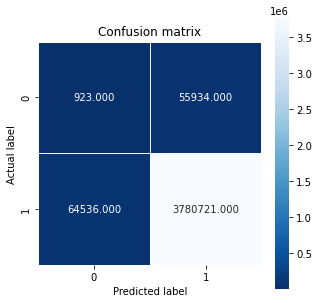

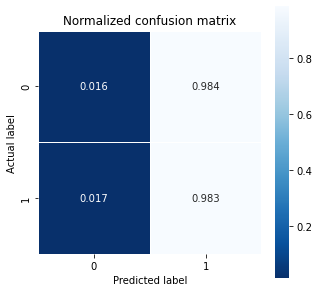

In [18]:
cm_gbt_MB = confusion_matrix(df_pd_data["C_SEV"], predictions_MB)
cm_gbt_norm_MB = confusion_matrix(df_pd_data["C_SEV"], predictions_MB, normalize="true")

plt.figure(figsize=(5,5))
sns.heatmap(cm_gbt_MB, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion matrix")

plt.figure(figsize=(5,5))
sns.heatmap(cm_gbt_norm_MB, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Normalized confusion matrix")

Podemos observar como el modelo base tiene un accuracy de 0.97 y las matrices de confusión son bastante malas ya que solamente se centran en predecir los no fallecimientos (debido al desbalanceo del dataset). Pero este modelo será nuestro modelo de referencia y, a partir de aquí, los modelos que vayamos obteniendo deberán ir mejorando este.

---

## LASSO

Lasso es una penalización dentro de las regresiones. Antes de explicar Lasso, debemos explicar qué es una penalización. 

**Def.** Una regularización es una penalización. Lo que se busca con la regularización es obligar, de alguna forma, a que el modelo elija las variables más importantes en función de un threshold. 

Esto será entendido de manera más clara con el caso particular de regularización *Lasso*

Supongamos que para un modelo dado, calculamos el error cuadrático medio o, también conocido por *MSE*. El error cuadrático medio se define de la siguiente forma:
<p style="text-align: center;">
MSE = $\sum_{i=1}^{M} (y_i - \bar{y}_i)^2$, tal que $\bar{y}_i$ y $y_i$ se refieren al valor predicho y al valor real respectivamente



Donde M es el número de muestras que tenemos. Luego, lo que se pretende hacer con la regularización Lasso es añadir un término de manera que penalice este error cuadrático medio. En otras palabras, el término de Lasso hará mas grande el MSE. Para escribir el desarrollo de manera adecuada, supongamos que tenemos una regresión lineal que se escribe de la siguiente forma:

<p style="text-align: center;">
$\bar{y} = w_{0} + w_{1}*x_{1} + w_{2}*x_{2} + ... + w_{n}*x_{n}$

Luego, nuestra predicción $\bar{y}$ no será mas que $w_{1}*x_{1} + w_{2}*x_{2} + ... + w_{n}*x_{n}$. Entonces, podemos escribir el error cuadrático medio como sigue:

<p style="text-align: center;">
MSE = $\sum_{i=1}^{M} (y_i - w_{0} - \sum_{j=1}^{n}w_{j}*x_{ij})^2$

Ahora, añadimos la penalización Lasso al error cuadrático medio.

<p style="text-align: center;">
MSE = $\sum_{i=1}^{M} (y_i - w_{0} - \sum_{j=1}^{n}w_{j}*x_{ij})^2 + \lambda*\sum_{j=0}^{n}w_{j}^2$ tal que $\lambda \in \mathbb{R}$

Es decir, obligamos a los coeficientes que sean muy bajos para que el error cuadrático medio no aumente exageradamente. El valor $\lambda$ indicará *cuánto quiero que importe esta penalización*. Esto nos dará como resultado que un número de variables serán más importantes que otras. 

**Importante.** Para hacer uso de Lasso, es necesario escalar las variables

Una vez vista la teoría, adentrémonos en la práctica. 

**Varibales a utilizar**
- *X_train_oversampled*: Dataset de training con la técnica de oversampling sin la variable respuesta 
- *y_train_oversampled*: Dataset de training de la variable target con la técnica de oversampling
- *x_test*: Dataset de testing sin la variable target

**Librerias a utilizar**
- SelectFromModel de sklearn.feature_selection 
- LogisticRegression, LinearRegression de sklearn.linear_model 
- Sklearn.metrics 
- Matplotlib.pyplot
- Pandas
- Seaborn

Primeramente, vamos a comprobar como evoluciona el número de variables y el roc_auc_score en función del threshold para un modelo de regresión logística (nos servirá para más adelante) y así poder elegir el modelo Lasso adeacuado para este modelo

In [ ]:
num_var=list()
ROC_score=list()
for i in np.arange(0.05, 0.15, 0.005):
    sel_lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear', max_iter=100), threshold = i)
    sel_lasso.fit(X_train_oversampled, y_train_oversampled)
    selected_feat_lasso = X_train_oversampled.columns[sel_lasso.get_support()]
    model = LogisticRegression(random_state=0)
    model.fit(X_train_oversampled[selected_feat_lasso], y_train_oversampled)
    sel_lasso.get_support()
    predictions_proba=model.predict_proba(x_test[selected_feat_lasso])
    num_var.append(len(selected_feat_lasso))
    ROC_score.append(roc_auc_score(ytest, predictions_proba[:,1]))
    # hacemos print de i para saber en cada momento por qué punto va el bucle
    print(i)

In [ ]:
data = {"threshold" :np.arange(0.05, 0.15, 0.005), 'Num_of_var':num_var, 'roc_score':ROC_score }
threshold_df = pd.DataFrame(data, columns=["threshold", "Num_of_var", "roc_score"])
threshold_df.index=threshold_df["threshold"]
threshold_df.drop("threshold", axis=1)

In [ ]:
sns.lineplot(data = threshold_df["Num_of_var"])

In [ ]:
sns.lineplot(data = threshold_df["roc_score"])

Viendo las gráficas, vemos que la segunda nos puede aportar quizás más información que la primera. Luego, basándonos en la segunda gráfica, podemos considerar como un buen threshold 0.1 ya que no perdemos mucho roc_auc_score y, nos quedamos con alrededor de 29 variables (gráfica de arriba).

Luego, calculemos Lasso con dicho threshold

In [ ]:
start_Lasso = time.time() 

In [ ]:
sel_lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'), threshold = 0.1) 
sel_lasso.fit(X_train_oversampled, y_train_oversampled)

In [ ]:
sel_lasso.get_support()
selected_feat_lasso = X_train_oversampled.columns[sel_lasso.get_support()]
selected_feat_lasso

In [ ]:
print('total features: {}'.format((X_train_oversampled.shape[1])))
print('selected features: {}'.format(len(selected_feat_lasso)))

In [ ]:
end_Lasso = time.time()

In [ ]:
df_coeficientes_lasso = pd.DataFrame(
                        {'predictor': X_train_oversampled.columns,
                         'coef': sel_lasso.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes_lasso.predictor, df_coeficientes_lasso.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo lasso');

En este gráfico podemos ver cuáles son las variables más "importantes" con respecto a Lasso. En el gráfico aparecen todas las variables de nuestro dataset y, las que menos importancia tienen son num_Random, num_C_YEAR, NA_sin_C_WDAY, NA_cos_C_MNTH. Luego, estas son las variables que eliminamos de nuestra importancia de variables.

---

# SELECCIÓN DE VARIABLES

## PCA

**Def**. El PCA o también conocido como análisis de componentes principales, es una técnica de reducción de dimensiones. Esta reducción de dimensiones se intenta que la varianza explicada por ellas sea lo mayor posible.

A continuación mostramos una descripción detallada del algoritmo PCA

El algoritmo tiene distintas fases, que explicamos a continuación:
- *Estandarización de los datos*. Estandarización implica tomar cada valor en una columna y restarle la media de dicha columna y luego dividir por la desviación típica de la columna.
- *Cálculo de la matriz de covarianzas*. La matriz de covarianzas es una matriz simétrica que en la diagonal principal tiene la varianza de las variables y en el resto de elementos (i,j) de la matriz la covarianzas tenemos precisamente la covarianza de los elementos i y j tal que i $\neq$ j.
- *Cálculo de autovalores y autovectores de la matriz de covarianzas*. 
- *Ordenación de los autovalores*. La primera de las componentes explica mayor varianza que la segunda (su autovalor es mayor), la segunda explica más que la tercera y así sucesivamente 
- *Cálculo de las componentes principales*. 

**Vatriables a utilizar**
- *X_train_oversampled*: Dataset de training con la técnica de oversampling sin la variable respuesta 
- *x_test*: Dataset de testing sin la variable target

**Librerias a utilizar**
- PCA de sklearn.decomposition 
- Matplotlib.pyplot
- Pandas

**Importante**: En el algoritmo de PCA necesitamos que las variables estén escaladas.

In [28]:
pca = PCA()

pca.fit(X_train_oversampled)
X_train_pca = pca.transform(X_train_oversampled)
X_test_pca = pca.transform(x_test)

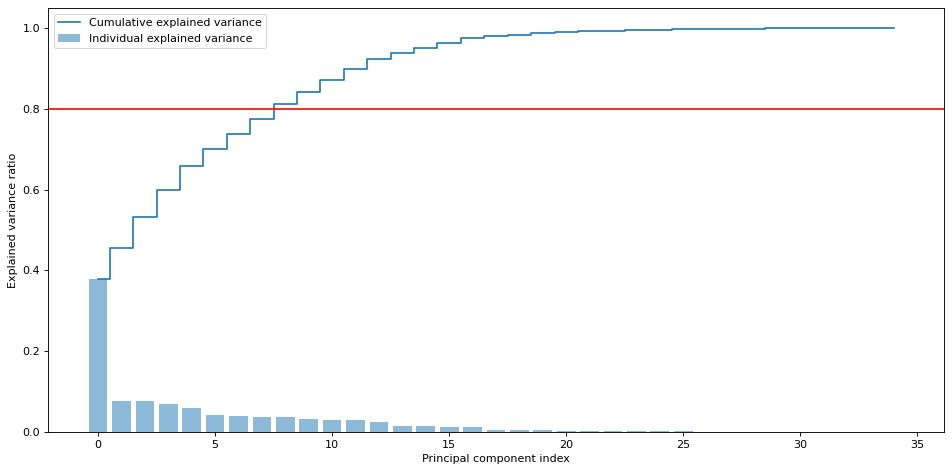

In [29]:
exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

threshold = 0.8
plt.figure(figsize=(12, 6), dpi=80)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.axhline(y=threshold, color='r', linestyle='-')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Una vez podemos ver el gráfico con la línea de corte marcada en 0.8, decidimos tomar 8 componentes principales. Para obtenerlas deberemos repetir el proceso indicando al PCA que tomaremos 8 componentes.

In [35]:
pca_2 = PCA(n_components=8)

pca_2.fit(X_train_oversampled)
X_train_pca_2 = pca_2.transform(X_train_oversampled)
X_test_pca_2 = pca_2.transform(x_test)

In [36]:
X_train_pca_2 = pd.DataFrame(X_train_pca_2)
X_test_pca_2 = pd.DataFrame(X_test_pca_2)
X_train_pca_2.columns = ['PCA_'+str(i) for i in X_train_pca_2.columns]
X_test_pca_2.columns = ['PCA_'+str(i) for i in X_test_pca_2.columns]
X_train_pca_2.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7
0,-0.924764,-1.198069,-0.100060,0.731248,-1.255774,-0.688106,0.267227,0.735365
1,-0.125883,-0.046912,-0.628025,-0.698322,-0.209955,-0.389655,-0.833715,-0.865821
2,-0.188498,0.123035,0.214586,-0.418556,-0.252945,0.468178,0.888110,1.217886
3,-0.126656,-1.651930,-0.905470,0.522026,0.735800,-0.446957,1.039603,1.420120
4,-0.135061,-0.216798,-1.431805,-1.134891,-0.157390,0.976589,-0.947736,0.163845


Estos nuevos conjuntos de training y testing nos servirá para hacer uso de ellos en los modelos y después comparar resultados.

---

# MODELOS

Antes de adentrarnos en los modelos, debemos fijar una serie de conceptos. Por un lado, hablemos de la *matriz de confusión*, de las *métricas* y de la *curva de ROC*.

**Matriz de confusión**. Las matrices de confusión se utilizan en problemas de clasificación. Cada columna de la matriz representa el número de predicciones de cada clase (en nuestro caso si habrá algún fallecido o no), mientras que cada fila representa lo ocurrido realmente. Esto es, en términos prácticos nos permite ver  qué tipos de aciertos y errores está teniendo nuestro modelo a la hora de pasar por el proceso de aprendizaje con los datos.

**Métricas**. Las métricas sirven para determinar el rendimiento de un modelo y, existen muchos tipos de métricas. Muchas de ellas se basan en las matrices de confusión.

**Curva de ROC**. La curva de ROC es la representación gráfica de la sensibilidad(recall) frente a la especificidad. Una métrica muy conocida es el área bajo la curva de roc. Esta medida toma valores entre 1 y 0.5. Esta métrica puede interpretarse como la probabilidad de que ante un par de individuos, uno fallecido y el otro no, la prueba los clasifique correctamente.

Estas son dos de las grandes cosas en las que nos tenemos que fijar para determinar la eficacia de nuestro modelo. En nuestro caso, debemos tener en cuenta que nuestro dataset es un dataset desvalanceado y, por ello, no tiene sentido tomar todas las métricas igual de importantes. Es por ello, que para este proyecto, en las métricas que más nos fijaremos serán el *recall*, *la curva de roc y el área bajo su curva* y, por supuesto *la matriz de confusión normalizada*. ¿Por qué elegimos el recall? Teniendo en cuenta que nuestro objetivo es predecir los fallecimientos de la mejor manera posible, esta medida será una de las más importantes ya que es la división entre los fallecidos acertados correctamente y el total de fallecidos. 


## MODELO GLM

Los modelos GLM o modelos lineales generalizados, como bien su nombre indica, son una generalización de los modelos de regresión lineal. Estos modelos aparecen en el momento que la variable target no es normal. 

**Observación.** Recordemos que una de las condiciones de las regresiones lineales simples y múltiples es que la variable target debe ser normal.

Por ello, si queremos predecir el número de personas que entrará a una tienda o si queremos predecir si alguien tiene una enfermedad o no, debemos hacer uso de los GLM.

Para poder predecir diferentes variables target, no normales, lo que hacemos es usar una *función de link* que sea invertible, de tal forma que:

<p style="text-align: center;">
$g(E(Y|X)) = w_{0} + w_{1}*x_{1} + w_{2}*x_{2} + ... + w_{n}*x_{n}$
    
Esto se resume en que si, por ejemplo queremos que nuestra variable target sea una probabilidad, por ejemplo podemos hacer uso de la función *logit*, la cual se define de la siguiente forma:
    
<p style="text-align: center;">
$logit(p) = \dfrac{p}{1-p}$, donde $p$ es la probabilidad de éxito

Así, utilizando esta función, tendríamos la siguiente ecuación:
        
<p style="text-align: center;">
$logit(p(X)) = w_{0} + w_{1}*x_{1} + w_{2}*x_{2} + ... + w_{n}*x_{n}$
    
Y despejando p(X) tenemos:
    
<p style="text-align: center;">
$p(X) = \dfrac{e^{w_{0} + w_{1}*x_{1} + w_{2}*x_{2} + ... + w_{n}*x_{n}}}{1 + e^{w_{0} + w_{1}*x_{1} + w_{2}*x_{2} + ... + w_{n}*x_{n}}}$   

Nosotros utilizaremos un caso particular de glm que es la *regresión logística*. En esta regresión, la función link de la que se hace uso es, por ejemplo, la función logit presentada anteriormente.

### Regresión logística con todas las variables

**Vatriables a utilizar**
- *X_train_oversampled*: Dataset de training con la técnica de oversampling sin la variable respuesta 
- *y_train_oversampled*: Variable objetivo con la técnica de oversampling (training)
- *x_test*: Dataset de testing codificada mediante one hot encoding
- *ytest*: Variable objetivo (dataset de testing)

**Librerias a utilizar**
- LogisticRegression de sklearn.linear_model 
- Sklearn.metrics 
- Pandas

Primero hacemos el modelo con todas las variables que tenemos en el dataset. Después, realizaremos otra vez el modelo pero sólamente utilizando las variables que nos proporciona Lasso

/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


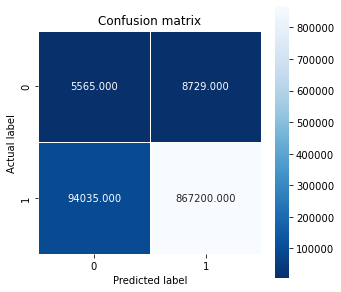

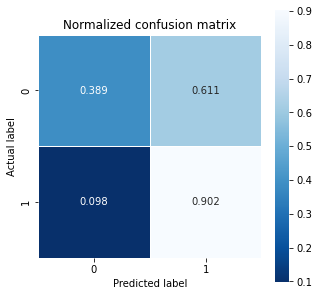

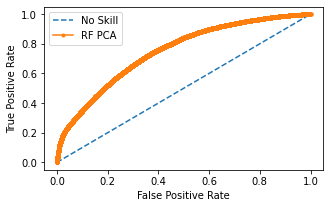

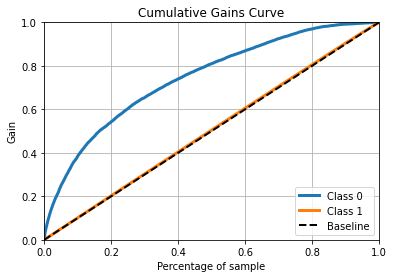

In [32]:
start_LOGREG, final_LOGREG, prediction_LOGREG, predictions_proba_LOGREG, LOGREG = modelos(X_train_oversampled, y_train_oversampled, x_test, sklearn.linear_model.LogisticRegression(), ytest)

El modelo de regresión logística vemos que mejora notablemente el modelo base que hemos obtenido antes.  Pero todavía se queda lejos de predecir bien los fallecimientos y, nosotros, como aseguradora, es nuestro principal interés.

In [34]:
medidas(ytest, prediction_LOGREG, predictions_proba_LOGREG)

,F1,roc_score,accuracy,recall
0,0.944064,0.748476,0.894658,0.902173


La regresión logística mediante Lasso no ha podido ser calculada debido a que ha habido un problema con el notebook de los modelos y hemos tenido que ejecutar todo de nuevo y, la segunda parte de Lasso no ha podido ser calculada.

### Regresión logística con selección de variables de Lasso

En esta ocacasión haremos uso de las variables seleccionadas en la penalización Lasso y, comprobaremos si el modelo de regresión logística ha mejorado o no

In [ ]:
start_LOGREG_LASSO, final_LOGREG_LASSO, prediction_LOGREG_LASSO, predictions_proba_LOGREG_LASSO, LOGREG_LASSO= modelos(X_train_oversampled[selected_feat_lasso], y_train_oversampled, x_test[selected_feat_lasso], sklearn.linear_model.LogisticRegression(), ytest)

In [ ]:
medidas(ytest, prediction_LOGREG, predictions_proba_LOGREG)

##### CONCLUSIONES

Los resultados del modelo de regresión logística no son malos si los comparamos con los obtenidos en el modelo base. Sin embargo, los modelos fallan mucho a la hora de intentar acertar los fallecidos y eso no nos interesa ya que buscamos el mayor número de aciertos posible en los individuos de la clase 0, es decir la clase de los fallecidos.

En cuanto a los tiempos de ejecución, éstos se muestran a continuación:

In [ ]:
time_LOGREG = [start_LOGREG, final_LOGREG]
time_LOGREG_LASSO = [start_LOGREG_LASSO, final_LOGREG_LASSO]\n
data_time_LOGREG = {"LOGREG": time_LOGREG, "LOGREG_LASSO":time_LOGREG_LASSO}
time_LOGREG = pd.DataFrame(data_time_LOGREG, columns=["LOGREG", "LOGREG_LASSO"])
time_LOGREG.index=["start", "end"]
time_LOGREG = time_LOGREG.transpose()
time_LOGREG["total_time(s)"] = time_LOGREG["end"]-time_LOGREG["start"]
time_LOGREG

Podemos comprobar que los tiempos de ejecución son muy parecidos pero, el tiempo de ejecución cuando hacemos uso de la importancia de variables proporcionada por Lasso, éste se reduce ligeramente.

---

## SVM

**Def.** SVM (Supported Vector Machine) es un algoritmo tanto de clasificación como de regresión. El SVM sirve para poder separar las clases mediante un hiperplano. En dos dimensiones la separación se hace con una recta, en tres co un plano y en una dimensión n, mediante un hiperplano de dimensión n-1.

**Ejemplo.** A continuación mostramos una figura como ejemplo del objetivo del algoritmo SVM en dos dimensiones. 

<div>
<img src="../Images/SVM.png" width="450"/>
</div>

Como se puede observar, el principal objetivo del SVM es separar las dos clases de tal forma que las bolas rojas queden a un lado del hiperplano (recta en este caso) y las bolas azules al otro lado del hiperplano

**Vatriables a utilizar**
- *X_train_oversampled*: Dataset de training con la técnica de oversampling sin la variable respuesta 
- *y_train_oversampled*: Variable target con la técnica de oversampling
- *x_test*: Dataset de testing

**Librerias a utilizar**
- SVC from sklearn.svm 
- Sklearn.metrics 

El modelo SVM no ha podido ejecutarse ya que ha estado apróximadamente unas 19 horas en ejecución y hemos tenido que detenerlo por falta de tiempo

---

## Random Forest

Antes de conocer el algoritmo de Random Forest, será necesario conocer primero los algoritmos de árboles de decisión.

**Def.** Los algoritmos de árboles de decisión, como bien su nombre indica, se basan en la representación de árbol donde cada nodo indica una variable y se separa en diferentes condiciones. Por ejemplo, si tengo una variable que me indica si una persona tiene coche o no, en el nodo de dicha variable el algoritmo se preguntará si tiene coche o no y en función de su respuesta recorrerá un camino u otro. 

Una representación de un árbol de decisión es la que se ve a continuación:

<div>
<img src="../Images/decision_tree.png" width="490"/>
</div>

**def.** El algoritmo de Random Forest es un algoritmo basado en árboles de decisión que sirve para resolver problemas de clasificación y de regresión. Este algoritmo es un claro ejemplo de técnica de ensamble de modelos. En otras palabras, Random Forest es el resultado de una combinación de modelos.

A la hora de hacer el ensamble existen dos grandes técnicas. Tenemos el ensamble por *bagging* y el ensamble por *boosting*. El algoritmo Random Forest es un ejemplo de técnica de bagging. Ahora bien, ¿en qué consiste la técnica de bagging? Esta técnica trata de seleccionar, de manera aleatoria, muestras y crear modelos un número finito de veces. De esta manera, si seleccionamos n muestras y creamos n modelos con todas las muestras y después combinamos los n modelos, estamos haciendo *bagging*.

En nuestro caso, trataremos el algoritmo RF como técnica de clasificación ya que lo que buscamos es predecir si un accidente tendrá o no fallecidos

**Librerias a utilizar**
- RandomForestClassifier from sklearn.ensemble
- Sklearn.metrics 
- Matplotlib.pyplot
- Seaborn
- Pandas

Puesto que nuestro objetivo es intentar predecir el número de fallecidos que habrá en un accidente (valor 0 en nuestra variable target), dado que el RF tiene un parámetro que se conoce por *class_weight*, vamos a crear un bucle en el que variaremos el peso del valor 0 en nuestra variable target para ver cuál de todos nos produce una mejor matriz de confusión y mejores valores en las métricas.

Después, utilizaremos ese valor óptimo del bucle para ver los modelos RF con y sin PCA y después comparar resultados.

/var/folders/3q/zfn8yb513nj10ry8w8r8_jmc0000gn/T/ipykernel_27717/3657829901.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train_oversampled, y_train_oversampled)


Las métricas para i=  3.0 son:
         F1  roc_score  accuracy    recall
0  0.992603   0.830403  0.985356  0.997136


/var/folders/3q/zfn8yb513nj10ry8w8r8_jmc0000gn/T/ipykernel_27717/3657829901.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train_oversampled, y_train_oversampled)


Las métricas para i=  3.5 son:
         F1  roc_score  accuracy    recall
0  0.992603   0.832046  0.985357  0.997146


/var/folders/3q/zfn8yb513nj10ry8w8r8_jmc0000gn/T/ipykernel_27717/3657829901.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train_oversampled, y_train_oversampled)


Las métricas para i=  4.0 son:
         F1  roc_score  accuracy    recall
0  0.992614   0.831602  0.985378  0.997143


/var/folders/3q/zfn8yb513nj10ry8w8r8_jmc0000gn/T/ipykernel_27717/3657829901.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train_oversampled, y_train_oversampled)


Las métricas para i=  4.5 son:
         F1  roc_score  accuracy    recall
0  0.992589   0.831479  0.985328  0.997133


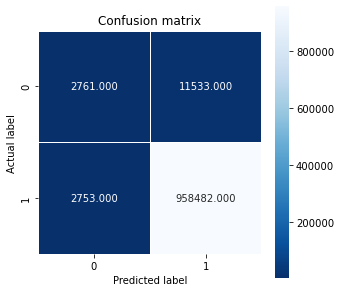

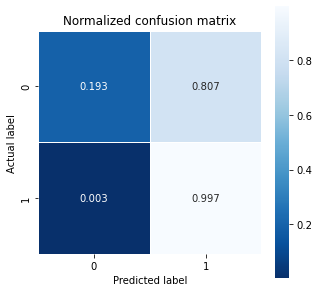

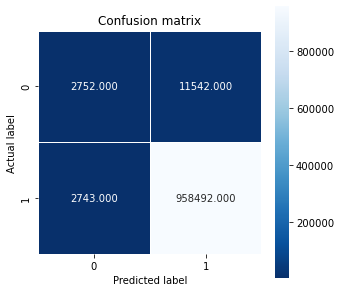

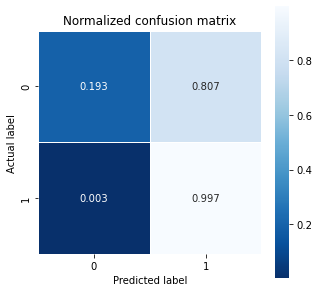

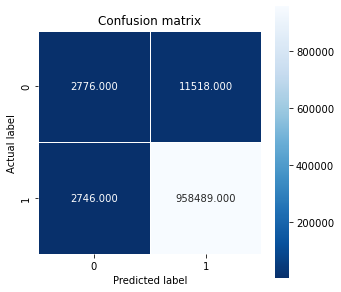

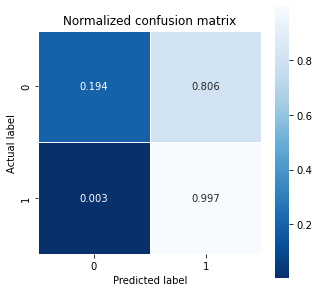

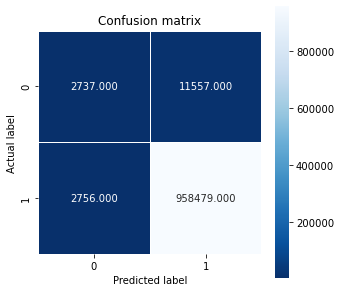

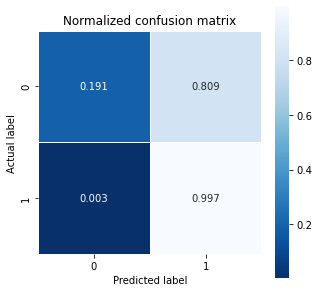

In [20]:
for i in np.arange(3, 5, 0.5):
    RF = RandomForestClassifier(n_estimators=100, class_weight={0:i, 1:0.05}, random_state=42)
    RF.fit(X_train_oversampled, y_train_oversampled)
    prediccion_Random_Forest = RF.predict(x_test)
    predictions_proba_RF = RF.predict_proba(x_test)
    cm = confusion_matrix(ytest, prediccion_Random_Forest)
    cm_norm = confusion_matrix(ytest, prediccion_Random_Forest, normalize="true")

    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.title("Confusion matrix")

    plt.figure(figsize=(5,5))
    sns.heatmap(cm_norm, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.title("Normalized confusion matrix")
    print("Las métricas para i= ", i, "son:")
    print(medidas(ytest, prediccion_Random_Forest, predictions_proba_RF))

Podemos comprobar que la diferencia es mínima, luego, no merece la pena hacer uso de este hiperparámetro en nuestros modelos de RandomForest.

### RANDOM FOREST SIN PCA

**Variables a utilizar:**
- *X_train_oversampled*: Dataset de training con la técnica de oversampling sin la variable respuesta 
- *y_train_oversampled*: Parte del training de la variable respuesta
- *x_test*: Dataset de testing
- *ytest*: Variable objetivo (dataset de testing)

/Users/aitor/Desktop/Máster Ciencia de Datos/Aprendizaje automático/Machine-Learning/big_practice/notebooks/FUNCIONES.py:226: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_train=model.fit(xtrain, ytrain)


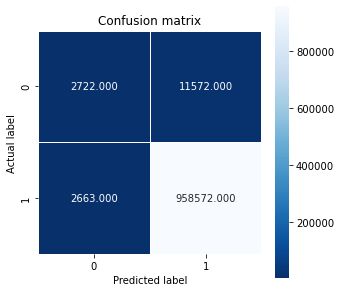

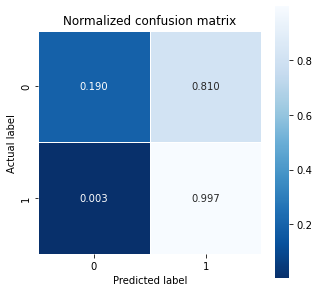

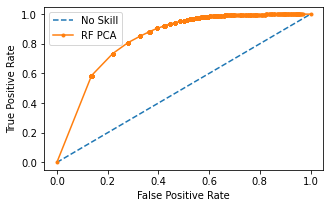

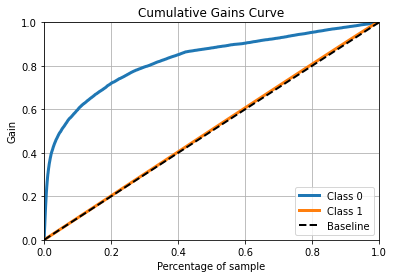

In [21]:
start_RF, final_RF, prediction_RF, predictions_proba_RF, RF=modelos(X_train_oversampled, y_train_oversampled, x_test, RandomForestClassifier(random_state=42), ytest)

Nuestro modelo clava los individuos de la clase 1 pero no los de la clase 0 (son quienes nos interesan), luego, deberemos modificar este modelo para que acierte más los individuos de la clase 0. ¿Cómo lo haremos? Lo conseguiremos considerando el threshold óptimo que nos proporciona la curva de ROC. Pero, ¿qué quiere decir esto que acabamos de decir? Debemos tener en cuenta que, el algoritmo, por defecto nos devuelve una probabilidad como predicción. Luego, el propio algoritmo se encarga de decidir a qué clase pertenece cada predicción en función de la probabilidad. Y, esta probabilidad, por defecto es 0.5. Esto quiere decir que, si la probabilidad devuelta por el algoritmo para un individuo i es mayor que 0.5, lo clasifica como de la clase 1, mientras que si por el contrario es menor o igual que 0.5, lo clasifica como de la clase 0. Luego, este umbral lo tenemos que introducir nosotros manualmente para que el problema sea real, puesto que no siempre es interesante que se divida en el valor 0.5. Y este umbral (o también conocido como threshold) nos lo dará la curva de ROC.

LA curva de ROC, como hemos explicado antes, es la representación gráfica del recall frente a la especificidad y lo que nos interesa es encontrar el punto óptimo entre recall y sensitividad. Ese punto óptimo será nuestro threshold. Veamos a continuación como podemos calcularlo.

##### THRESHOLD ÓPTIMO MEDIANTE LA CURVA DE ROC

In [22]:
yhat_RF = predictions_proba_RF[:, 1]
fpr_RF, tpr_RF, thresholds_RF = roc_curve(ytest, yhat_RF)

Best Threshold=0.978333, F-Score=0.763


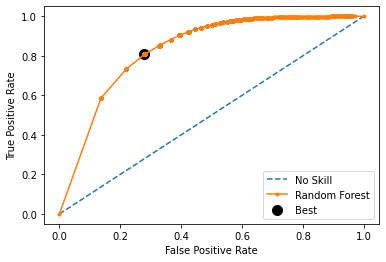

In [23]:
gmeans_RF = np.sqrt(tpr_RF * (1-fpr_RF))
ix_RF = np.argmax(np.sqrt(tpr_RF * (1-fpr_RF)))
predictions_roc_RF=(predictions_proba_RF[:,1] >= thresholds_RF[ix_RF]).astype(int)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds_RF[ix_RF], gmeans_RF[ix_RF]))

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr_RF, tpr_RF, marker='.', label='Random Forest')
plt.scatter(fpr_RF[ix_RF], tpr_RF[ix_RF], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

Para nuestro modelo, el threshold óptimo se da en 0.98. Luego, con el vector de predicciones nuevo calculado, volvemos a sacar las matrices de confusión.

Text(0.5, 1.0, 'Normalized confusion matrix')

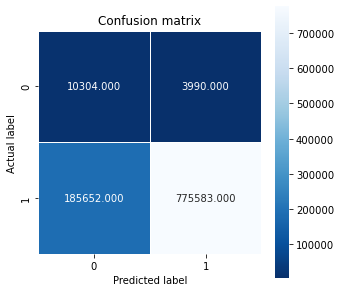

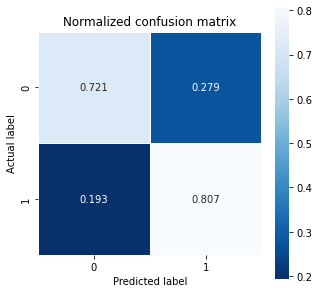

In [24]:
cm_RF_roc = confusion_matrix(ytest, predictions_roc_RF)
cm_norm_RF_roc = confusion_matrix(ytest, predictions_roc_RF, normalize="true")

plt.figure(figsize=(5,5))
sns.heatmap(cm_RF_roc, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion matrix")

plt.figure(figsize=(5,5))
sns.heatmap(cm_norm_RF_roc, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Normalized confusion matrix")

El rendimiento del modelo ha incrementado notablemente al considerar las nuevas predicciones que hemos calculado mediante el threshold óptimo. Tenemos un total de aciertos en fallecidos de casi el 75%, lo cual no es del todo una mala cifra. Veamos los resultado numéricos analizando los resultados de las diferentes métricas.

##### MÉTRICAS

In [25]:
medidas(ytest, predictions_roc_RF, predictions_proba_RF)

,F1,roc_score,accuracy,recall
0,0.891061,0.833413,0.805601,0.806861


Si nos fijamos en las métricas recall y roc_score, podemos observar que tanto el roc_score como el recall no tienen malos valores. El recall está cercano a 0.8 y el roc_score cercano a 0.85. Luego, de momento, este modelo parece el mejor entre los que hemos analizado.

Ahora, guardamos el modelo en un formato pickle con el nombre *RF*

In [26]:
with open('../Models/RF.pickle', 'wb') as f:
    pickle.dump(RF, f)

Ahora, vamos a plantear el mismo algoritmo de RF pero únicamente introduciendo las componentes obtenidas en el PCA. Después, compararemos los resultados obtenidos y finalmente, decidiremos si merece la pena introducir el PCA en el algoritmo RF o no.

### RANDOM FOREST CON PCA

**Variables a utilizar:**
- *X_train_pca_2*: Dataset de training obtenido con la técnica de selección de variables PCA 
- *y_train_oversampled*: Parte del training de la variable respuesta
- *X_test_pca_2*: Dataset de testing obtenido con la técnica de seleccioón de variables PCA 
- *ytest*: Variable objetivo (dataset de testing)

/Users/aitor/Desktop/Máster Ciencia de Datos/Aprendizaje automático/Machine-Learning/big_practice/notebooks/FUNCIONES.py:226: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_train=model.fit(xtrain, ytrain)


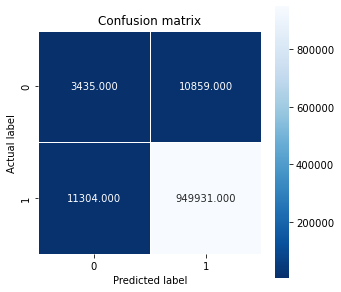

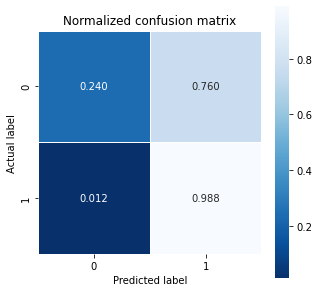

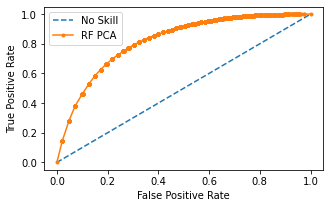

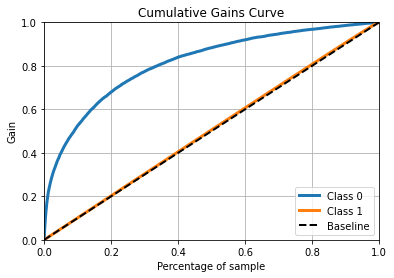

In [37]:
start_RF_PCA, final_RF_PCA, prediction_RF_PCA, predictions_proba_RF_PCA, RF_PCA= modelos(X_train_pca_2, y_train_oversampled, X_test_pca_2, RandomForestClassifier(random_state=42), ytest)

##### THRESHOLD ÓPTIMO MEDIANTE LA CURVA DE ROC

In [38]:
yhat_RF_PCA = predictions_proba_RF_PCA[:, 1]
fpr_RF_PCA, tpr_RF_PCA, thresholds_RF_PCA = roc_curve(ytest, yhat_RF_PCA)

Best Threshold=0.890000, F-Score=0.745


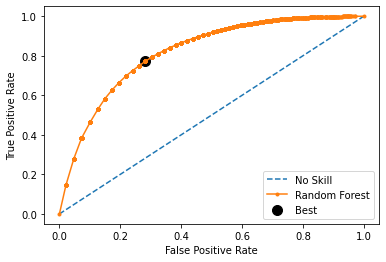

In [39]:
gmeans_RF_PCA = np.sqrt(tpr_RF_PCA * (1-fpr_RF_PCA))
ix_RF_PCA = np.argmax(np.sqrt(tpr_RF_PCA * (1-fpr_RF_PCA)))
predictions_roc_RF_PCA=(predictions_proba_RF_PCA[:,1] >= thresholds_RF_PCA[ix_RF_PCA]).astype(int)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds_RF_PCA[ix_RF_PCA], gmeans_RF_PCA[ix_RF_PCA]))

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr_RF_PCA, tpr_RF_PCA, marker='.', label='Random Forest')
plt.scatter(fpr_RF_PCA[ix_RF_PCA], tpr_RF_PCA[ix_RF_PCA], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

Repetimos las matrices de confusión considerando el threshold ofrecido por la curva ROC:

Text(0.5, 1.0, 'Normalized confusion matrix')

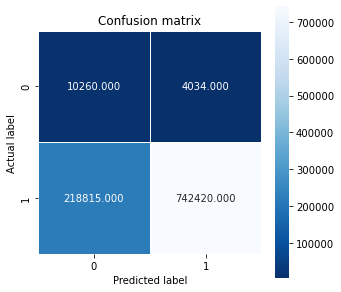

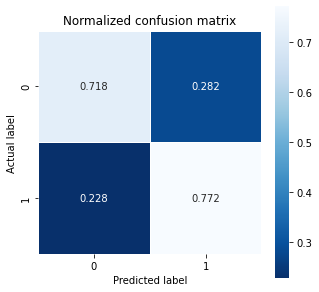

In [40]:
cm_RF_PCA_roc = confusion_matrix(ytest, predictions_roc_RF_PCA)
cm_norm_RF_PCA_roc = confusion_matrix(ytest, predictions_roc_RF_PCA, normalize="true")

plt.figure(figsize=(5,5))
sns.heatmap(cm_RF_PCA_roc, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion matrix")

plt.figure(figsize=(5,5))
sns.heatmap(cm_norm_RF_PCA_roc, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Normalized confusion matrix")

Las matrices de confusión han mejorado, como era de esperar, hasta llegar a un 75% de aciertos para los individuos de la clase 0. Sin embargo, si comparamos las matrices obtenidas con el RF sin PCA y estas, podemos observar que las matrices del primer modelo son bastante mejores que estas, es por ello que se concluye que no merece la pena utilizar el PCA en este caso. Después veremos los tiempos de ejecución para comparar.

Veamos las métricas de este modelo.

##### MÉTRICAS

In [41]:
medidas(ytest, predictions_roc_RF_PCA, predictions_proba_RF_PCA)

,F1,roc_score,accuracy,recall
0,0.869503,0.819026,0.771561,0.772361


Se demuestra lo mencionado anteriormente, tanto el recall como el área bajo la curva ROC son menores que en el primer modelo. Luego, el primer modelo supera al RF con PCA en términos de resultados. Veamos qué ocurre con el tiempo.

Ahora, guardamos el modelo en un formato pickle con el nombre *RF_PCA*

In [42]:
with open('../Models/RF_PCA.pickle', 'wb') as f:
    pickle.dump(RF_PCA, f)

Una vez tenemos ambos resultados, podemos concluir que merece la pena 

##### CONCLUSIONES

Primeramente, los tiempos de ejecución para ambos modelos es el siguiente:

In [43]:
time_RF = [start_RF, final_RF]
time_RF_PCA = [start_RF_PCA, final_RF_PCA]
data_time_RF = {"RF": time_RF, "RF_PCA":time_RF_PCA}
time_RF = pd.DataFrame(data_time_RF, columns=["RF", "RF_PCA"])
time_RF.index=["start", "end"]
time_RF = time_RF.transpose()
time_RF["total_time(s)"] = time_RF["end"]-time_RF["start"]
time_RF

,start,end,total_time(s)
RF,1.641248e+09,1.641251e+09,2128.870260
RF_PCA,1.641251e+09,1.641253e+09,2518.487846


En términos de cómputo, resulta curioso que en este caso el modelo que más ha tardado ha sido el modelo en el que hacemos uso de PCA y la diferencia es bastante grande, casi el doble. Además, hemos podido comprobar que el RandomForest nos ha proporcionado mejores resultados, debido a que acierta bastante bien los accidentes de la clase 0 y muestra buenísimos resultados con los individuos de la clase 1. Luego, claramente el modelo con el que nos quedamos es el guardado con el nombre RF.

---

## XGBoost

**Def.** El algoritmo XGBBoost, al igual que el Random Forest, es un algoritmo de ensamble basado en árboles de decisión. 

Este algoritmo también hace uso de la técnica de ensamblaje pero lo hace mediante boosting. ¿En qué consiste el boosting? En bagging, todos los datos tienen la misma probabilidad de ser elegidos en cada iteración. Sin embargo, en boosting no ocurre esto. Esto se resume en que la técnica de boosting insiste más en lo que más se falla. En otras palabras, en cada iteración, este algoritmo asigna una serie de pesos a cada punto del dataset, en función de los fallos que encuentre en la iteración anterior.

Esto puede tener ventajas y desventajas frente al random forest. La gran ventaja es que es más preciso pero, la mayor desventaja es el tiempo de ejecución ya que XGBoost no puede empezar con la siguiente iteración sin haber acabado la anterior.

**Librerias a utilizar**
- Xgboost as xgb
- Sklearn.metrics
- XGBClassifier from xgboost 

### XGBOOST SIN PCA

**Variables a utilizar:**
- *X_train_oversampled*: Dataset de training con la técnica de oversampling sin la variable respuesta 
- *y_train_oversampled*: Parte del training de la variable respuesta
- *x_test*: Dataset de testing modificado con la función de escalado
- *ytest*: Variable objetivo (dataset de testing)

/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the

[00:42:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


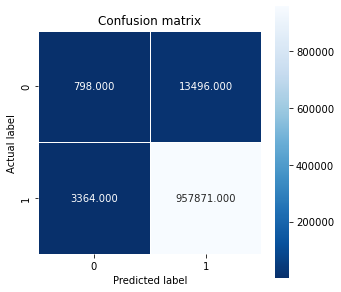

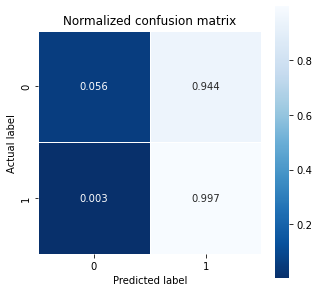

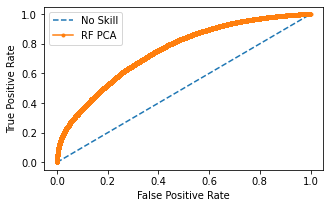

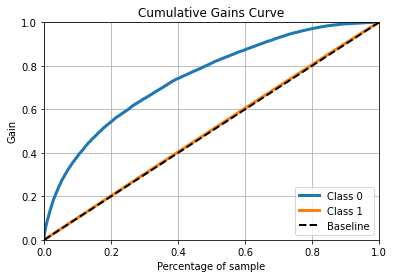

In [44]:
start_XGB, final_XGB, prediction_XGB, predictions_proba_XGB, XGB= modelos(X_train_oversampled, y_train_oversampled, x_test, XGBClassifier(), ytest)

A primera vista, el modelo es realmente malo. Luego, para mejorar el rendimiento del mismo, deberemos calcular el threshold óptimo mediante la curva de ROC al igual que lo hemos hecho para los casos de RandomForest.

##### THRESHOLD ÓPTIMO MEDIANTE LA CURVA DE ROC

In [45]:
yhat_XGB = predictions_proba_XGB[:, 1]
fpr_XGB, tpr_XGB, thresholds_XGB = roc_curve(ytest, yhat_XGB)

Best Threshold=0.942401, F-Score=0.678


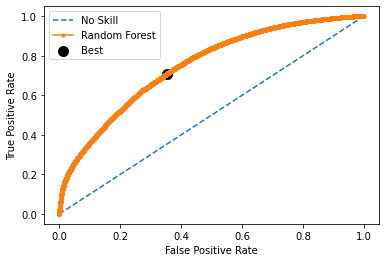

In [46]:
gmeans_XGB = np.sqrt(tpr_XGB * (1-fpr_XGB))
ix_XGB = np.argmax(np.sqrt(tpr_XGB * (1-fpr_XGB)))
predictions_roc_XGB=(predictions_proba_XGB[:,1] >= thresholds_XGB[ix_XGB]).astype(int)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds_XGB[ix_XGB], gmeans_XGB[ix_XGB]))

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr_XGB, tpr_XGB, marker='.', label='XGB')
plt.scatter(fpr_XGB[ix_XGB], tpr_XGB[ix_XGB], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

##### MATRICES DE CONFUSIÓN CON THRESHOL ÓPTIMO

Text(0.5, 1.0, 'Normalized confusion matrix')

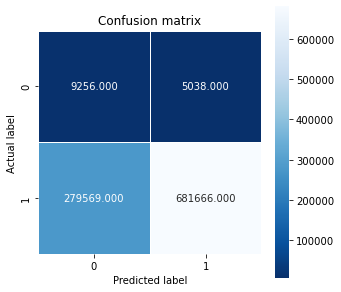

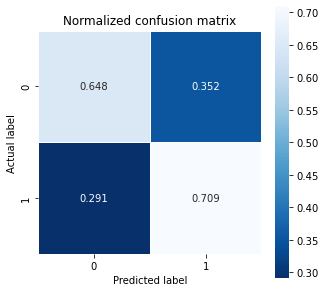

In [47]:
cm_XGB_roc = confusion_matrix(ytest, predictions_roc_XGB)
cm_norm_XGB_roc = confusion_matrix(ytest, predictions_roc_XGB, normalize="true")

plt.figure(figsize=(5,5))
sns.heatmap(cm_XGB_roc, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion matrix")

plt.figure(figsize=(5,5))
sns.heatmap(cm_norm_XGB_roc, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Normalized confusion matrix")

Vemos como el modelo ha cambiado completamente. Acertamos más que antes, pero seguimos estando lejos del objetivo de predecir los fallecidos ya que fallamos demasiado. Es por ello que, viendo el modelo de RandomForest que hemos obtenido anteriormente, este modelo no nos dice gran cosa. Veamos cuáles son los valores de las métricas.

##### MÉTRICAS

In [48]:
medidas(ytest, prediction_XGB, predictions_proba_XGB)

,F1,roc_score,accuracy,recall
0,0.991276,0.750648,0.982717,0.9965


Ahora, guardamos el modelo en un formato pickle con el nombre *XGB*

In [49]:
with open('../Models/XGB.pickle', 'wb') as f:
    pickle.dump(XGB, f)

Veamos qué ocurre con el mismo modelo XGBoost pero, haciendo uso del PCA.

### XGBOOST CON PCA

**Variables a utilizar:**
- *X_train_pca_2*: Dataset de training obtenido con la técnica de selección de variables PCA 
- *y_train_oversampled*: Parte del training de la variable respuesta
- *X_test_pca_2*: Dataset de testing obtenido con la técnica de seleccioón de variables PCA 
- *ytest*: Variable objetivo (dataset de testing)

/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the

[00:47:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


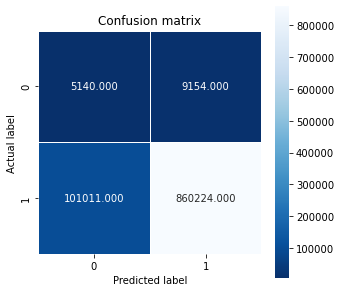

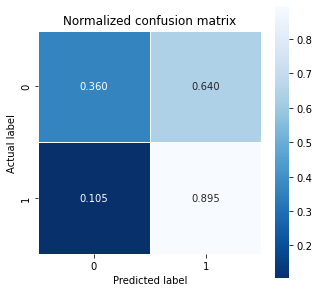

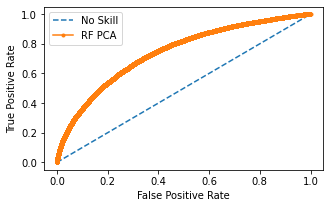

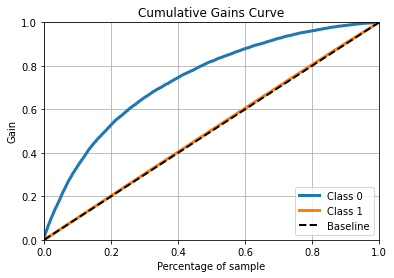

In [50]:
start_XGB_PCA, final_XGB_PCA, prediction_XGB_PCA, predictions_proba_XGB_PCA, XGB_PCA= modelos(X_train_pca_2, y_train_oversampled, X_test_pca_2, XGBClassifier(), ytest)

La mtriz de confusión que se obtiene tiene una mejor forma que la que hemos obtenido antes al ejecutar el XGBoost sin PCA y sin el threshold de ROC. La mejor forma se debe a que acertamos más los fallecidos que antes. Sin embargo, introduzcamos el threshold de ROC para ver si el modelo puede llegar a superar al de RandomForest obtenido anteriormente.

##### THRESHOLD ÓPTIMO MEDIANTE LA CURVA DE ROC

In [51]:
yhat_XGB_PCA = predictions_proba_XGB_PCA[:, 1]
fpr_XGB_PCA, tpr_XGB_PCA, thresholds_XGB_PCA = roc_curve(ytest, yhat_XGB_PCA)

Best Threshold=0.713791, F-Score=0.681


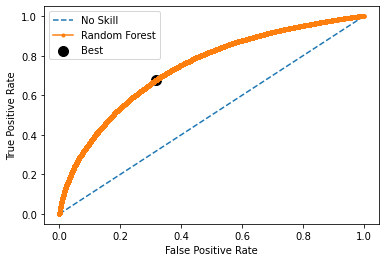

In [52]:
gmeans_XGB_PCA = np.sqrt(tpr_XGB_PCA * (1-fpr_XGB_PCA))
ix_XGB_PCA = np.argmax(np.sqrt(tpr_XGB_PCA * (1-fpr_XGB_PCA)))
predictions_roc_XGB_PCA=(predictions_proba_XGB_PCA[:,1] >= thresholds_XGB_PCA[ix_XGB_PCA]).astype(int)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds_XGB_PCA[ix_XGB_PCA], gmeans_XGB_PCA[ix_XGB_PCA]))

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr_XGB_PCA, tpr_XGB_PCA, marker='.', label='XGB_PCA')
plt.scatter(fpr_XGB_PCA[ix_XGB_PCA], tpr_XGB_PCA[ix_XGB_PCA], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

Repetimos las matrices de confusión considerando el threshold ofrecido por la curva roc:

Text(0.5, 1.0, 'Normalized confusion matrix')

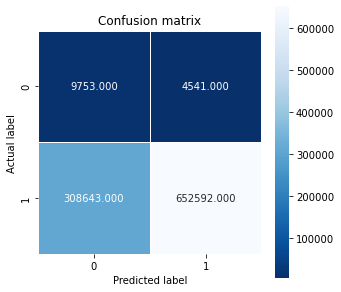

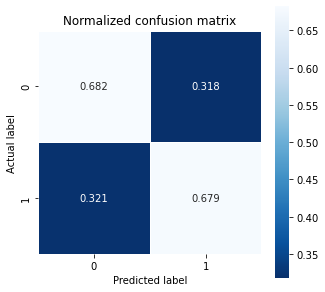

In [53]:
cm_XGB_PCA_roc = confusion_matrix(ytest, predictions_roc_XGB_PCA)
cm_norm_XGB_PCA_roc = confusion_matrix(ytest, predictions_roc_XGB_PCA, normalize="true")

plt.figure(figsize=(5,5))
sns.heatmap(cm_XGB_PCA_roc, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion matrix")

plt.figure(figsize=(5,5))
sns.heatmap(cm_norm_XGB_PCA_roc, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Normalized confusion matrix")

Analizando las matrices, y fijándonos en la que más información nos proporciona que es la normalizada, vemos que el modelo ha mejorado con respecto al XGBoost sin PCA en el ámbito de acierto de fallecidos, pero con una probabilidad de casi un 70% todavía nos seguimso quedando con el mejor modelo hasta ahora, el RandomForest. Veamos las métricas de nuestro modelo.

##### MÉTRICAS

In [54]:
medidas(ytest, predictions_roc_XGB_PCA, predictions_proba_XGB_PCA)

,F1,roc_score,accuracy,recall
0,0.806482,0.741901,0.67896,0.67891


......

Guardamos el modelo en formato pickle con el nombre de *XGB_PCA*.

In [55]:
with open('../Models/XGB_PCA.pickle', 'wb') as f:
    pickle.dump(XGB_PCA, f)

##### CONCLUSIONES

En primer lugar, mostraremos los tiempos de ejecución.

In [56]:
time_XGB = [start_XGB, final_XGB]
time_XGB_PCA = [start_XGB_PCA, final_XGB_PCA]
data_time_XGB = {"XGB": time_XGB, "XGB_PCA":time_XGB_PCA}
time_XGB = pd.DataFrame(data_time_XGB, columns=["XGB", "XGB_PCA"])
time_XGB.index=["start", "end"]
time_XGB = time_XGB.transpose()
time_XGB["total_time(s)"] = time_XGB["end"]-time_XGB["start"]
time_XGB

,start,end,total_time(s)
XGB,1.641253e+09,1.641254e+09,295.001058
XGB_PCA,1.641254e+09,1.641254e+09,268.070656


Los tiempos de ejecución rondan los 6 minutos para el modelo XGboost y los 5 minutos para el modelo XGBoost con PCA. Como era de esperar, el tiempo de ejecución para PCA es mejor ya que introducimos un número reducido de variables. Además, hemos comprobado que el XGBoost con PCA nos proporciona mejores resultados, teniendo en cuenta nuestro objetivo, que el XGBoost. Luego, en este caso, merece la pena considerar el modelo de XGBoost con PCA.

Sin embargo, comparando el mejor modelo obtenido con el algoritmo de boosting XGBoost, no alcanzamos al modelo RandomForest que hemos mostrado antes. Luego, deberemos descartar el algoritmo XGBoost para nuestro problema.

---

## Light GBM

**def**. Light GBM, al igual que el XGBoost, es un algoritmo de boosting que se basa en árboles de decisión. A diferencia de los algoritmos vistos anteriormente, los árboles en Light GBM crecen de manera vertical. La decisión de ir creciendo la va tomando en función a 

Por esa misma razón, este algoritmo está más optimizado que el XGBoost ya que su velocidad de entrenamiento es mayor. A continuación mostramos una ilustración en la que podemos apreciar la diferencia entre el crecimiento de algoritmos como XGBoost y el crecimiento del algoritmo Light GBM.

<div>
<img src="../Images/LightGBM_crecimiento.png" width="450"/>
</div>

**Librerias a utilizar**
- Lightgbm
- Sklearn.metrics
- Matplotlib.pyplot
- Pandas
- Seaborn

### LIGHT GBM SIN PCA

**Variables a utilizar:**
- *X_train_oversampled*: Dataset de training con la técnica de oversampling sin la variable respuesta 
- *y_train_oversampled*: Parte del training de la variable respuesta
- *x_test*: Dataset de testing modificado con la función de escalado
- *ytest*: Variable objetivo (dataset de testing)

Haciendo uso de la función *modelos*, calculamos el tiempo inicial, final, la predicción normal y la probabilística y también el modelo entrenado, para así después, poder guardarlo en formato pickle.

/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


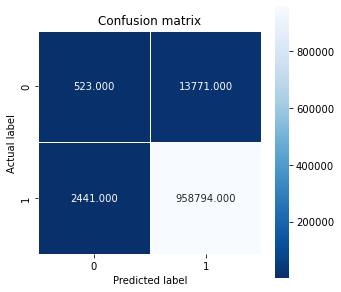

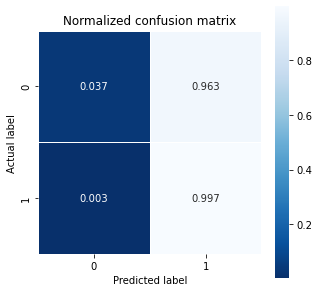

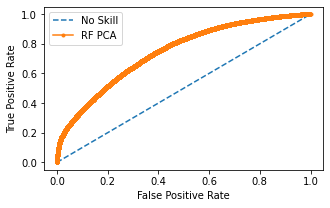

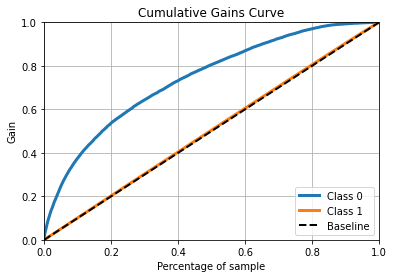

In [57]:
start_LGBM, final_LGBM, prediction_LGBM, predictions_proba_LGBM, LGBM = modelos(X_train_oversampled, y_train_oversampled, x_test, lgb.LGBMClassifier(random_state=42), ytest)

De igual forma que nos ha ocurrido con XGBoost, los resultados que obtenemos al ejecutar el modelo son malos. Todos las predicciones se nos van a la clase 1, es decir, a los no fallecidos. La curva de ROC y la de ganancia ......

Puesto que todavía estamos lejos de nuestro objetivo, planteamos el mismo modelo pero considerando el threshold óptimo que nos proporciona la curva de ROC.

##### THRESHOLD ÓPTIMO MEDIANTE LA CURVA DE ROC

In [58]:
yhat_LGBM = predictions_proba_LGBM[:, 1]
fpr_LGBM, tpr_LGBM, thresholds_LGBM = roc_curve(ytest, yhat_LGBM)

Ahora, generamos las nuevas predicciones teniendo en cuenta nuestro nuevo threshols.

Best Threshold=0.928852, F-Score=0.674


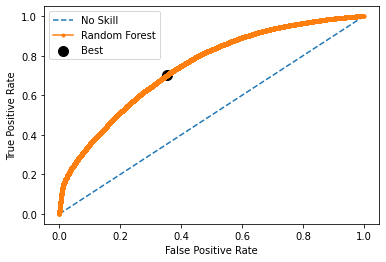

In [59]:
gmeans_LGBM = np.sqrt(tpr_LGBM * (1-fpr_LGBM))
ix_LGBM = np.argmax(np.sqrt(tpr_LGBM * (1-fpr_LGBM)))
predictions_roc_LGBM=(predictions_proba_LGBM[:,1] >= thresholds_LGBM[ix_LGBM]).astype(int)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds_LGBM[ix_LGBM], gmeans_LGBM[ix_LGBM]))

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr_LGBM, tpr_LGBM, marker='.', label='LGBM')
plt.scatter(fpr_LGBM[ix_LGBM], tpr_LGBM[ix_LGBM], s=100, marker='o', color='black', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

El threshold obtenido, como se puede comprobar, es de 0.93.

Repetimos las matrices de confusión considerando el nuevo vector de predicciones obtenido mediante el threshold óptimo:

Text(0.5, 1.0, 'Normalized confusion matrix')

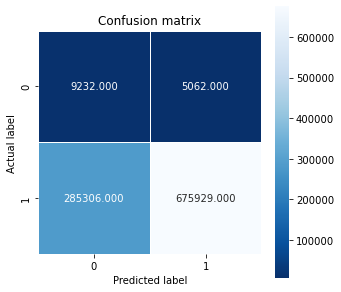

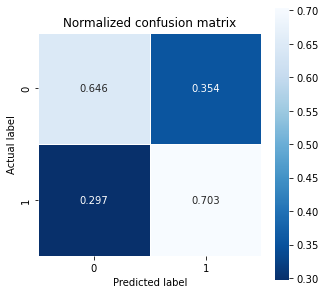

In [60]:
cm_LGBM_roc = confusion_matrix(ytest, predictions_roc_LGBM)
cm_norm_LGBM_roc = confusion_matrix(ytest, predictions_roc_LGBM, normalize="true")

plt.figure(figsize=(5,5))
sns.heatmap(cm_LGBM_roc, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion matrix")

plt.figure(figsize=(5,5))
sns.heatmap(cm_norm_LGBM_roc, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Normalized confusion matrix")

La mejoría es notable en las matrices de confusión, como se puede apreciar, pero, al igual que con el algoritmo XGBoost, todavía falla mucho en los individuos de la clase 0, comprobemos las métricas para verlo numéricamente.

##### MÉTRICAS

In [61]:
medidas(ytest, predictions_roc_LGBM, predictions_proba_LGBM)

,F1,roc_score,accuracy,recall
0,0.823186,0.744689,0.702348,0.703188


Parece que nuestras sospechas eran ciertas puesto que el recall y el roc_score no son valores muy elevados. 

Ahora, guardamos el modelo en un formato pickle con el nombre *LGBM*

In [62]:
with open('../Models/LGBM.pickle', 'wb') as f:
    pickle.dump(LGBM, f)

### LIGHT GBM CON PCA

**Variables a utilizar:**
- *X_train_pca_2*: Dataset de training obtenido con la técnica de selección de variables PCA 
- *y_train_oversampled*: Parte del training de la variable respuesta
- *X_test_pca_2*: Dataset de testing obtenido con la técnica de seleccioón de variables PCA 
- *ytest*: Variable objetivo (dataset de testing)

/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


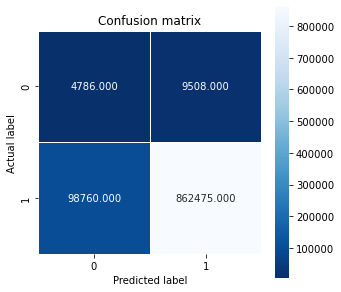

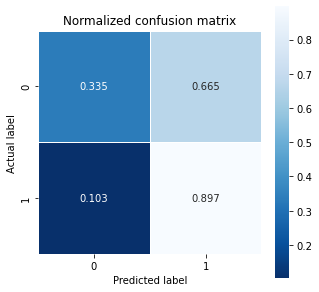

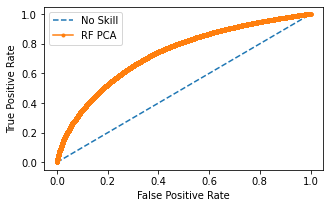

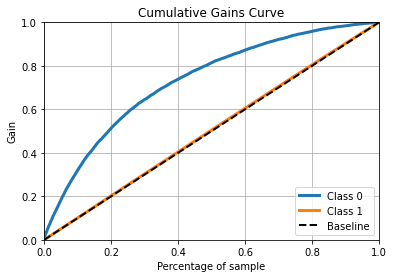

In [63]:
start_LGBM_PCA, final_LGBM_PCA, prediction_LGBM_PCA, predictions_proba_LGBM_PCA, LGBM_PCA = modelos(X_train_pca_2, y_train_oversampled, X_test_pca_2, lgb.LGBMClassifier(random_state=42), ytest)

Como podemos observar, la matriz de confusión del modelo no es nada buena. Para tener otra visión del modelo, calcularemos el threshol óptimo mediante la curva de ROC. Esto permitirá que el umbral en el que se decide que la predicción es fallecido o no fallecido cambie, y, por tanto, la matriz de confusión cambiará.

##### THRESHOLD ÓPTIMO MEDIANTE LA CURVA DE ROC

In [64]:
yhat_LGBM_PCA = predictions_proba_LGBM_PCA[:, 1]
fpr_LGBM_PCA, tpr_LGBM_PCA, thresholds_LGBM_PCA = roc_curve(ytest, yhat_LGBM_PCA)

Best Threshold=0.711524, F-Score=0.676


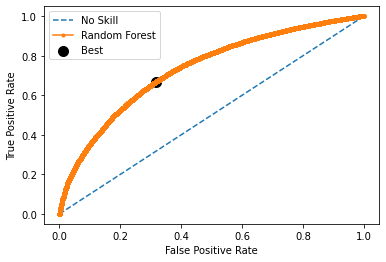

In [65]:
gmeans_LGBM_PCA = np.sqrt(tpr_LGBM_PCA * (1-fpr_LGBM_PCA))
ix_LGBM_PCA = np.argmax(np.sqrt(tpr_LGBM_PCA * (1-fpr_LGBM_PCA)))
predictions_roc_LGBM_PCA=(predictions_proba_LGBM_PCA[:,1] >= thresholds_LGBM_PCA[ix_LGBM_PCA]).astype(int)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds_LGBM_PCA[ix_LGBM_PCA], gmeans_LGBM_PCA[ix_LGBM_PCA]))

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr_LGBM_PCA, tpr_LGBM_PCA, marker='.', label='LGBM_PCA')
plt.scatter(fpr_LGBM_PCA[ix_LGBM_PCA], tpr_LGBM_PCA[ix_LGBM_PCA], s=100, marker='o', color='black', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

Una vez tenemos el vector de predicciones con la curva ROC, mostramos nuevamente la matriz de confusión.

Text(0.5, 1.0, 'Normalized confusion matrix')

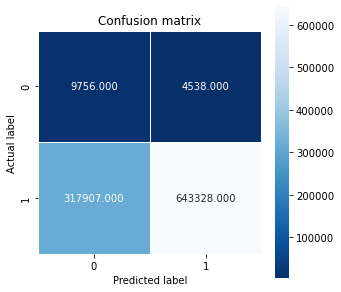

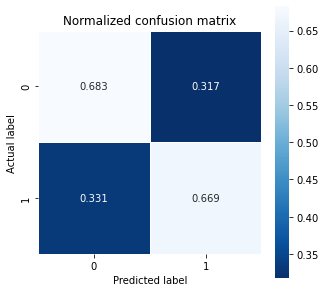

In [66]:
cm_LGBM_PCA_roc = confusion_matrix(ytest, predictions_roc_LGBM_PCA)
cm_norm_LGBM_PCA_roc = confusion_matrix(ytest, predictions_roc_LGBM_PCA, normalize="true")

plt.figure(figsize=(5,5))
sns.heatmap(cm_LGBM_PCA_roc, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion matrix")

plt.figure(figsize=(5,5))
sns.heatmap(cm_norm_LGBM_PCA_roc, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Normalized confusion matrix")

Claramente las matrices cambian y, el rendimiento del modelo no es malo del todo. Veamos ahora las métricas del modelo mediante la función *medidas*.

##### MÉTRICAS

In [67]:
medidas(ytest, predictions_roc_LGBM_PCA, predictions_proba_LGBM_PCA)

,F1,roc_score,accuracy,recall
0,0.799612,0.734045,0.669467,0.669272


Ahora, guardamos el modelo en un formato pickle con el nombre *LGBM_PCA*

In [68]:
with open('../Models/LGBM_PCA.pickle', 'wb') as f:
    pickle.dump(LGBM_PCA, f)

##### CONCLUSIONES

Los tiempos de ejecución se muestran a continuación.

In [69]:
time_LGBM = [start_LGBM, final_LGBM]
time_LGBM_PCA = [start_LGBM_PCA, final_LGBM_PCA]
data_time_LGBM = {"LGBM": time_LGBM, "LGBM_PCA":time_LGBM_PCA}
time_LGBM = pd.DataFrame(data_time_LGBM, columns=["LGBM", "LGBM_PCA"])
time_LGBM.index=["start", "end"]
time_LGBM = time_LGBM.transpose()
time_LGBM["total_time(s)"] = time_LGBM["end"]-time_LGBM["start"]
time_LGBM

,start,end,total_time(s)
LGBM,1.641254e+09,1.641254e+09,18.108950
LGBM_PCA,1.641254e+09,1.641254e+09,11.173289


Hemos podido comprobar que los modelos light GBM planteados (con y sin PCA) generan unos resultados muy parecidos, aunque también se pueden apreciar ligeros cambios en la matriz de confusión. El modelo Light GBM con PCA hace más incapié en los fallecimientos acertados que el modelo sin PCA. De esa manera, el modelo sin PCA acierta más en los accidentes en los que no hay fallecidos.

---

# Mejor modelo con modificación de hiperparámetros

Después de haber analizado todos los modelos, hemos podido comprobar que el mejor es el RandomForest debido a su gran rendimiento en la matriz de confusión normalizada.

Ahora, lo que deberemos hacer será tomar el modelo RandomForest e intentar encontrar sus hiperparámetros óptimos. Para ello, lo que se debe hacer es tomar diferentes hiperparámetros e iterar. Crear un modelo para cada uno de estos hiperparámetros que definamos y, después determinar cual es el mejor de todos los modelos.

Para ello, definimos un pipeline con el modelo de RandomForest. 

In [70]:
RandF = Pipeline(steps=[('classifier', RandomForestClassifier(random_state=42))])

Mediante el atributo .get_params() podemos obtener todos los hiperparámetros que tiene el RandomForest.

In [71]:
RandF.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'classifier', 'classifier__bootstrap', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__max_samples', 'classifier__min_impurity_decrease', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classifier__min_weight_fraction_leaf', 'classifier__n_estimators', 'classifier__n_jobs', 'classifier__oob_score', 'classifier__random_state', 'classifier__verbose', 'classifier__warm_start'])

En nuestro caso, la optimización de hiperparámetros la haremos con la función RandomizedSearCV. Realizar todas las combinaciones de hiperparámetros requiere un alto coste computacional ya que estaríamos aplicando lo conocido como *fuerza bruta*. Por ello, el algoritmo RandomizedSearchCV consiste en muestrear al azar a partir de una variedad de parámetros. De esta forma, este algoritmo no prueba todas las combinaciones posibles de valores sino que sólamente un número de ellas. 

In [ ]:
param_grid = { 
    'classifier__n_estimators': [20, 50, 100], 
    #'classifier__class_weight': [{0:5.1, 1:0.05}, {0:6.1, 1:0.05}, {0:7.1, 1:0.05}],
    'classifier__max_depth' : [6,8,10, 12],
    'classifier__criterion' :["gini", "entropy"]}

start_hiperparam=time.time()

CV = RandomizedSearchCV(RandF, param_grid, cv=10, random_state=42, n_jobs=2, scoring="roc_auc")
                  
BM = CV.fit(X_train_oversampled, y_train_oversampled)  
print(CV.best_params_)    
print(CV.best_score_)

end_hiperparam = time.time()

/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/pyt

/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/pyt

In [ ]:
prediction_BM = CV.predict(x_test)

In [ ]:
predictions_proba_BM = CV.predict_proba(x_test)

In [ ]:
cm_Best_model = confusion_matrix(ytest, prediction_Best_model)
cm_norm_Best_model = confusion_matrix(ytest, prediction_Best_model, normalize="true")

plt.figure(figsize=(5,5))
sns.heatmap(cm_Best_model, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion matrix")

plt.figure(figsize=(5,5))
sns.heatmap(cm_norm_Best_model, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Normalized confusion matrix")

In [ ]:
yhat_BM = predictions_proba_BM[:, 1]
fpr_BM, tpr_BM, thresholds_BM = roc_curve(ytest, yhat_BM)

In [ ]:
gmeans_BM = np.sqrt(tpr_BM * (1-fpr_BM))
ix_BM = np.argmax(np.sqrt(tpr_BM * (1-fpr_BM)))
predictions_roc_BM=(predictions_proba_BM[:,1] >= thresholds_BM[ix_BM]).astype(int)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds_BM[ix_BM], gmeans_BM[ix_BM]))

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr_BM, tpr_BM, marker='.', label='Random Forest')
plt.scatter(fpr_BM[ix_BM], tpr_BM[ix_BM], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

Una vez tenemos el vector de probabilidades actualizado con la curva de roc, hallamos la matriz de confusión óptima.

In [ ]:
cm_Best_model_roc = confusion_matrix(ytest, predictions_roc_BM)
cm_norm_Best_model_roc = confusion_matrix(ytest, predictions_roc_BM, normalize="true")

plt.figure(figsize=(5,5))
sns.heatmap(cm_Best_model_roc, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion matrix")

plt.figure(figsize=(5,5))
sns.heatmap(cm_norm_Best_model_roc, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Normalized confusion matrix")

In [ ]:
print(\"El tiempo de ejecución de la optimización de hiperparámetros es: ", end_hiperparam-start_hiperparam, "s")

Podemos comprobar, que aunque la optimización de hiperparámetros nos diga que es el mejor modelo que hemos encontrado, no es del todo cierto. Las mtrices de confusión que hemos obtenido para el modelo RF son bastante mejores. Luego, parece, que en nuestro caso la optimización de hiperparámetros no ha dado sus frutos y nos tenemos que quedar con el modelo RF que hemos definido anteriormente.

In [ ]:
with open('../Models/BM.pickle', 'wb') as f:
    pickle.dump(BM, f)